# Evaluation
This notebook contains code to reproduce the results presented in the Energy Informatics Open Journal. 

## Testing

In [1]:
import random
import warnings
import numpy as np
import pandapower
import inspect
from ipywidgets import Button, HBox, VBox
from pathlib import Path

from communication.network import CommNetwork
from cyber.analysis import Analyzer
from attackers.random_attacker import RandomAttacker

def run_experiment(seed:int=42, spec:str="Default", grid:str="create_cigre_network_mv", grid_kwargs:dict={},
                   criticality=None, save_name:str|None=None,
                   param_name:str="children_per_parent", param_values:list=[2, 3, 5, 8, 13, 21, 34, lambda network: network.n_devices],
                   n_attacks:int=1000, flatten:bool=False, **kwargs):
    np.random.seed(seed); random.seed(seed)
    print(f"Seed: {seed}")

    grid_map = {name:creator for name, creator in inspect.getmembers(pandapower.networks, predicate=inspect.isfunction)}
    with warnings.catch_warnings():
        warnings.filterwarnings(action="ignore", category=FutureWarning)
        grid = grid_map.get(grid)(**grid_kwargs)
        criticality = criticality(grid, verbose=False)[0] if criticality is not None else criticality
        spec_path = Path.cwd() / "specifications" / f"{spec.capitalize()}_specifications.json"
        network = CommNetwork(n_entrypoints=kwargs.get("n_entrypoints", 1), child_no_deviation=kwargs.get("child_no_deviation", 0),
                              children_per_parent=kwargs.get("children_per_parent", 3),
                              sibling_to_sibling_comm=kwargs.get("sibling_to_sibling_comm", None),
                              criticality=criticality,
                              network_specs=spec_path, grid=grid)
    print(f"Number of Components: {network.n_components}")

    # Total number of attacks: no_of_components * N_ATTACKS
    param_values = [val(network) if inspect.isfunction(val) else val for val in param_values]
    analyzer = Analyzer(network)
    exp_desc = '_'.join([w.capitalize() for w in param_name.split('_')])
    kwarg_desc = '-'.join(f"{k}_{v}" for k,v in kwargs.items())
    save_name = save_name if save_name is not None else f"{exp_desc}" + (f"--{kwarg_desc}" if kwarg_desc else "")
    archive_path = Path.cwd() / "data" / f"{save_name}.npz"
    print(f"Archive Path: '{archive_path}'")

    def run_monte(event):
        print("Running New Monte Carlo Simulation (Estimated Time to Completion: 40 minutes)")
        if len(param_values) > 1:
            compromised_array, effort_array, criticality_array = analyzer.monte_carlo_multi_analysis(seed=seed, 
                                                                                    n_attacks=n_attacks,
                                                                                    child_no_deviation=0,
                                                                                    grid=grid,
                                                                                    vary_entrypoints=kwargs.get("vary_entrypoints", True),
                                                                                    effort_only=kwargs.get("effort_only", False),
                                                                                    criticality=criticality,
                                                                                    param_name=param_name, 
                                                                                    param_values=param_values)
        else:
            compromised_array, effort_array, criticality_array = analyzer.monte_carlo_analysis(
                n_attacks=n_attacks, attacker_variant=RandomAttacker, budget=kwargs.get("budget",52), device_only=False, 
                sibling_to_sibling_comm=kwargs.get("sibling_to_sibling_comm", None), vary_entrypoints=kwargs.get("vary_entrypoints", True),
            )
        np.savez(archive_path, compromise=compromised_array, effort=effort_array, criticality=criticality_array) # .flatten()
        analyzer.plot_monte(save_name=save_name, figsize=(14, 16) if not math.isclose(np.mean(criticality_array), 0) else (14,12) flatten=flatten)

    def load_previous(event):
        print("Loading Previous Session")
        arrays = np.load(archive_path)
        compromised_array = arrays.get("compromise")
        effort_array = arrays.get("effort")
        criticality_array = arrays.get("criticality", np.zeros_like(compromised_array))
        analyzer.res_monte = {**{"compromised":compromised_array, "effort":effort_array, "criticality":criticality_array},
                              **({} if len(param_values) == 1 else {"param_name":param_name, "param_values":param_values})}
        analyzer.plot_monte(save_name=save_name, figsize=(14, 16) if "criticality" in arrays else (14,12), flatten=flatten)

    run_button = Button(description="Run Monte", button_style="info", style=dict(font_size="Large"), continuous_update=False)
    run_button.on_click(run_monte)
    load_button = Button(description="Load Previous", button_style="info", style=dict(font_size="Large"), continuous_update=False, disabled=False if archive_path.exists() else True)
    load_button.on_click(load_previous)
    box = HBox([run_button, load_button])
    display(box)

### Redundancy
Investigate the effect of redundancy (no. of children per parent) on the compromise and effort distribution of a communication network. 

In [ ]:
run_experiment(seed=42, spec="Default", grid="create_cigre_network_mv", grid_kwargs={"with_der":"all"},
               param_name="children_per_parent", param_values=[2, 3, 5, 8, 13, 21, 34, lambda network: network.n_devices],
               flatten=True,
               n_attacks=1000)

### Budget
Investigate the effect of increasing the budget of attackers on the same communication network.
Effort Only means probability-of-success on defenses is ignored, if the effort threshold is met then that component is always compromised.


In [ ]:
run_experiment(seed=42, spec="Default", grid="create_cigre_network_mv", grid_kwargs={"with_der":"all"},
               param_name="budget", param_values=[0.1, 1, 5, 10, 50, 100], # 250, 500, 1000, 2500, 5000, 10000
               children_per_parent = 3,
               flatten=True,
               effort_only=True, # Ignore success distributions
               n_attacks=1000)

### Susceptibility

Seed: 42
Number of Components: 194
Archive Path: 'c:\Users\Deuce\Documents\projects\Threats2Power\data\Susceptibility52.npz'


Running New Monte Carlo Simulation (Estimated Time to Completion: 40 minutes)


Attack : 100%|██████████| 10000/10000 [03:48<00:00, 43.73it/s]
Entrypoint : 194it [10:46:40, 200.00s/it]


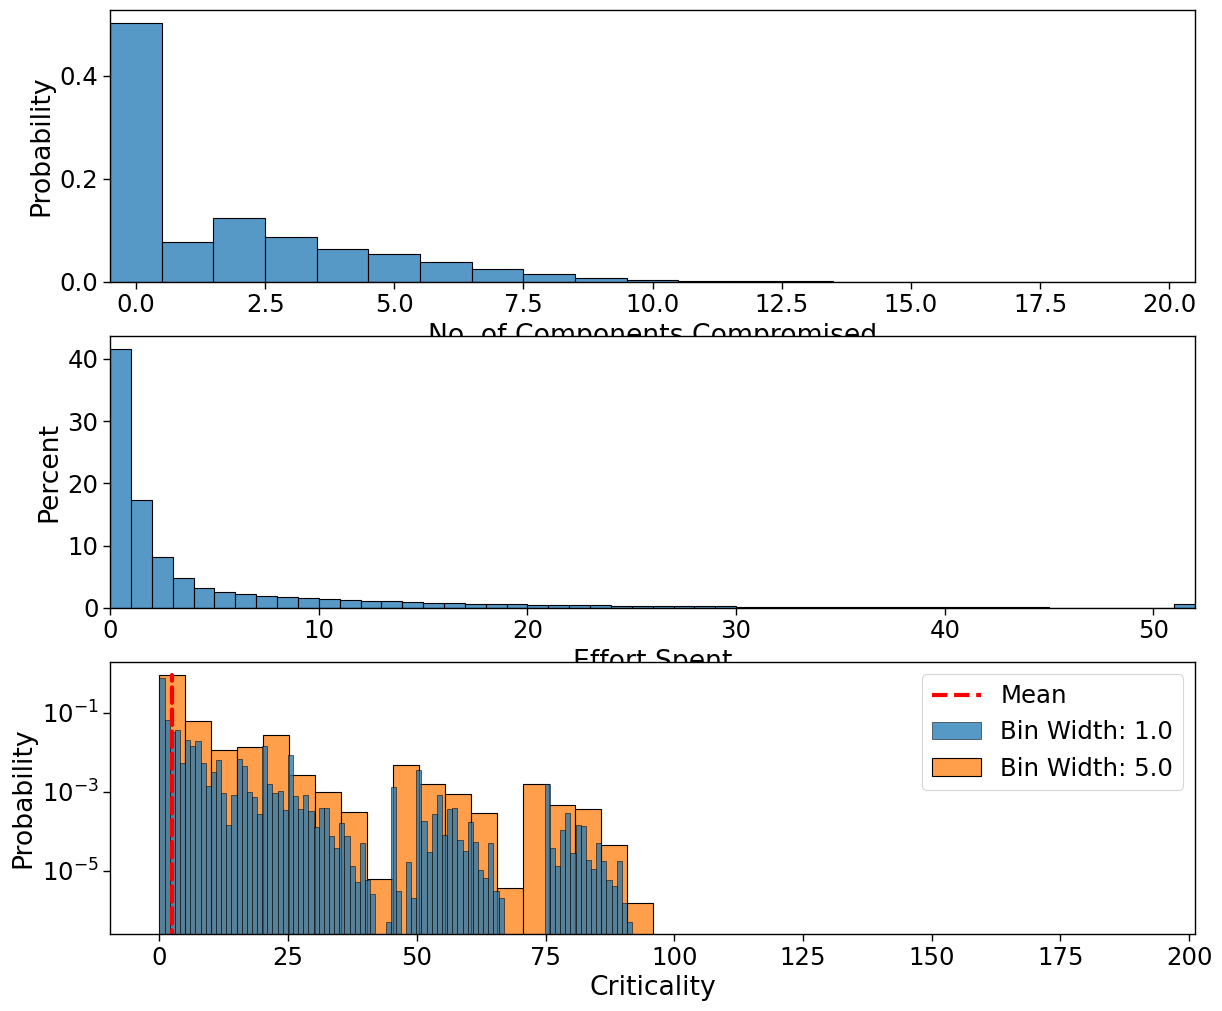

<Figure size 640x480 with 0 Axes>

In [ ]:
from cyber.criticality import criticality_by_degree, criticality_by_power_flow, criticality_by_capacity

run_experiment(seed=42, spec="Default", grid="create_cigre_network_mv", grid_kwargs={"with_der":"all"},
               param_name="budget", param_values=[52], save_name="Susceptibility52",
               children_per_parent = 0, child_no_deviation=3, sibling_to_sibling_comm="all", vary_entrypoints=True,
               flatten=True,
               criticality=criticality_by_capacity, 
               n_attacks=10000)

### Sibling-to-Sibling Communication


In [5]:
run_experiment(seed=42, spec="Default", grid="create_cigre_network_mv", grid_kwargs={"with_der":"all"},
               param_name="sibling_to_sibling_comm", param_values=[False, "adjacent", "all"],
               vary_entrypoints=True,
               save_name="siblings",
               flatten=True,
               n_attacks=10000)

Seed: 42
Number of Components: 176
Archive Path: 'c:\Users\Deuce\Documents\projects\Threats2Power\data\siblings.npz'


### Vary Entrypoints
Show effect of attacking from different entrypoints, using colorscale instead of a Legend.

In [ ]:
run_experiment(seed=42, spec="Default", grid="create_cigre_network_mv", grid_kwargs={"with_der":"all"},
               param_name="budget", param_values=[52], save_name="VariedEntrypoints",
               children_per_parent = 0, child_no_deviation=3, sibling_to_sibling_comm="all", vary_entrypoints=True,
               flatten=False,
               criticality=criticality_by_capacity, 
               n_attacks=10000)